# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL (CS-401). 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### Import libraries

In [1]:
from utils import *

pd.set_option('display.max_columns', None)

## 1. Datasets 📂

### 1.1 Import dataset

In [2]:
## Firt time imports
 
# Convert txt to csv
#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

<div class="alert alert-block alert-danger">
<b>Danger:</b> 
Change function to read directly from zip file!
</div>

In [3]:
## Files already converted, so we can load them directly

reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### 1.2 Initial datasets analysis 🔎

#### 1.2.1 Beers dataset 🍺

In [4]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
86615,64408,Penalty Shot Porter,22230,Jack's Brewing Company,American Porter,0,0,NaN,NaN,NaN,5.8,NaN,NaN,0,NaN
17991,187079,La Pitoune,17233,Microbrasserie La Chouape,Belgian Strong Pale Ale,0,0,NaN,NaN,NaN,6.7,NaN,NaN,0,NaN
44302,99518,Beera Burro,15578,The Dancing Camel Brewing Co.,Scottish Ale,3,1,3.59,NaN,NaN,6.0,3.606667,NaN,0,NaN


Shape of beers :  (280823, 15)


In [5]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

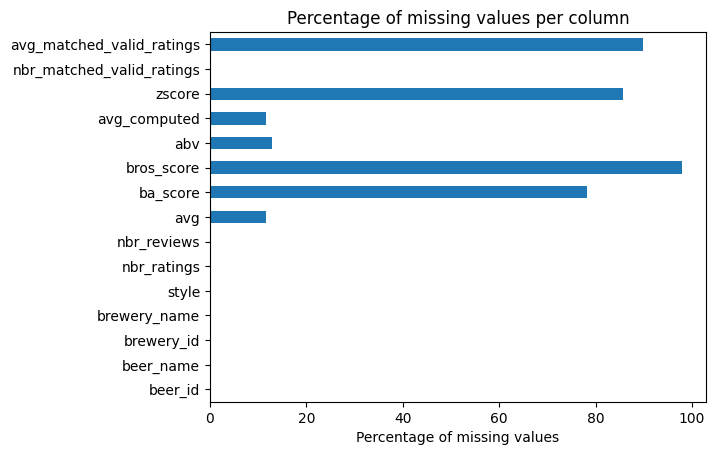

avg                      : 32829 missing values (11.69%)
ba_score                 : 219623 missing values (78.21%)
bros_score               : 275121 missing values (97.97%)
abv                      : 36024 missing values (12.83%)
avg_computed             : 32841 missing values (11.69%)
zscore                   : 240538 missing values (85.65%)
avg_matched_valid_ratings: 252551 missing values (89.93%)


In [6]:
show_missing(beers)

<blockquote>

**More comments about the dataset**

-We see that more than 80% of the beers do not have a z-score value. Since this value takes into account reviews from both websites and is vastly missing, we can drop the column alongside avg_computed. We might compute them manually later if needed.

-80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

-The other columns with NaN such as avg_matched_valid_ratings, avg_computed or bros_score are not useful in our analysis since we only look at the BeerAdvocate reviews.

-The column abv, which represents the alcohol percentage in a beer, is missing for approximately 12%.

</blockquote>

In [7]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [8]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
146611,120548,33934,American Amber / Red Ale,1,0,3.50,6.1
136050,168462,418,American IPA,263,53,3.56,4.8
139607,111531,32810,American Double / Imperial IPA,8,0,3.69,9.5


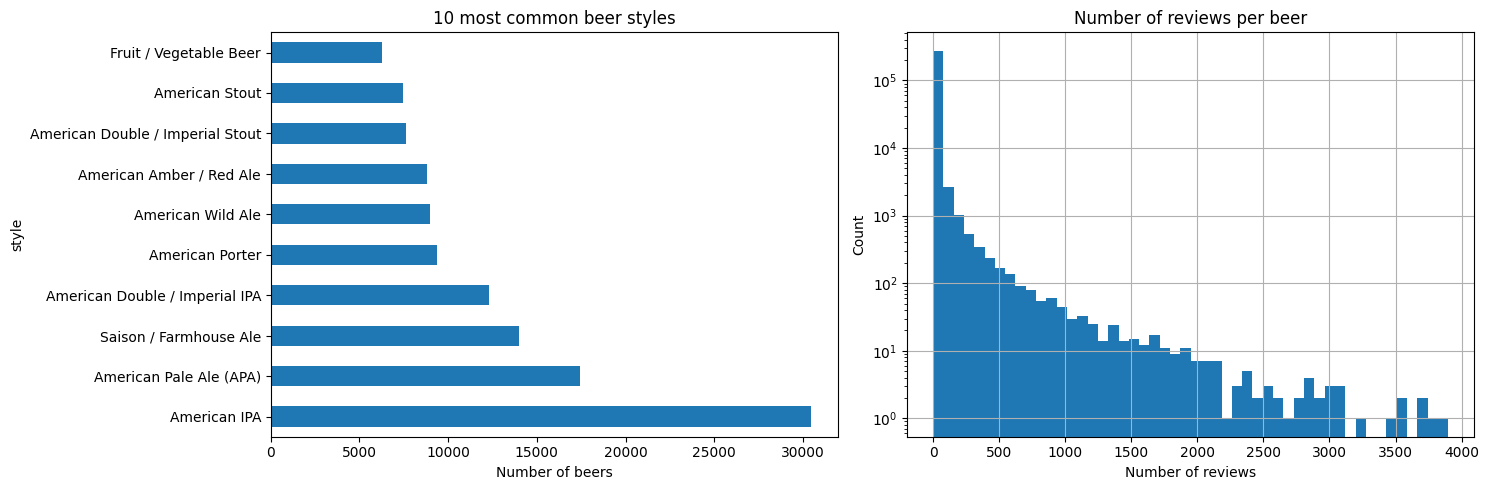

In [9]:
# Representation of the beers dataset
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

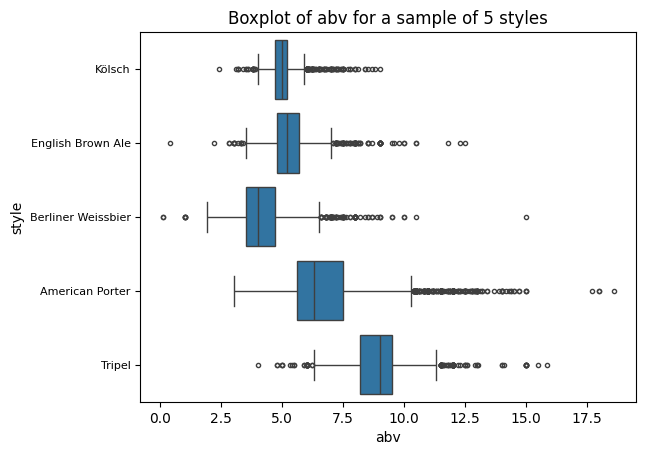

In [10]:
# boxplot of abv for sample of beers 
plt.figure()
sample_styles = beers_filtered['style'].sample(5)  # Select a sample of 5 beer styles
sns.boxplot(y='style', x='abv', data=beers_filtered[beers_filtered['style'].isin(sample_styles)], fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for a sample of 5 styles')
plt.show()

In [11]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
# display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

In [12]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### 1.2.2 Breweries dataset 🏭

In [13]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
10898,12997,"United States, Indiana",Ram Restaurant & Brewery,4
13467,33827,"United States, Oregon",Awesome Ales,6
5243,28318,Russia,OOO Suchanpivo,0


Shape of breweries :  (16758, 4)


In [14]:
# show the missing values
show_missing(breweries)

There are no missing values in this dataset.


<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [15]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [16]:
display(breweries_filtered.sample(3))
print('Shape of breweries filtered: ', breweries_filtered.shape)

,brewery_id,brewery_location,brewery_nbr_beers
16729,16099,"United States, Florida",0
13875,33844,"United States, Texas",18
2101,13236,Canada,12


Shape of breweries filtered:  (16758, 3)


In [17]:
# Some breweries have weird location values, they contain google maps links. All the breweries with a weird location value are in the US.
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [18]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'
    
# function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [19]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [20]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [21]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [22]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


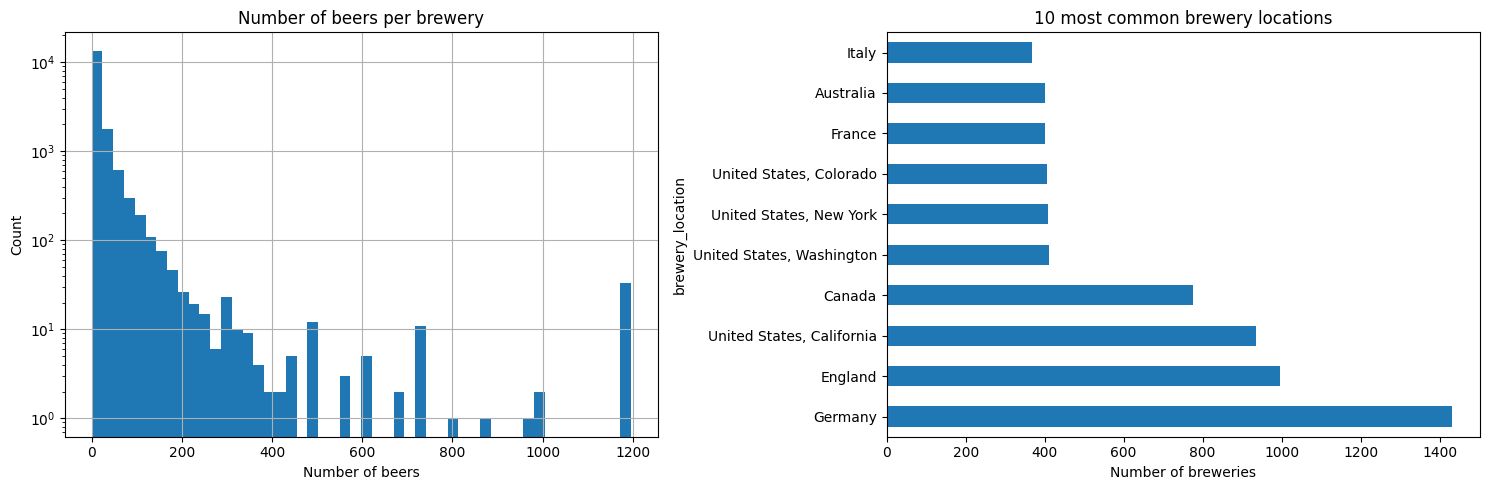

In [23]:
# Representation of beers per brewery and most common brewery locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### 1.2.3 Users dataset 👤

In [24]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
141327,1,0,nategreenman.458124,nategreenman,1.273572e+09,"United States, Michigan"
37576,5,5,matthaus_2000.1103523,matthaus_2000,1.454497e+09,Canada
92841,1,1,dubyn.913669,Dubyn,1.419419e+09,"United States, Washington"


Shape of users :  (153704, 6)


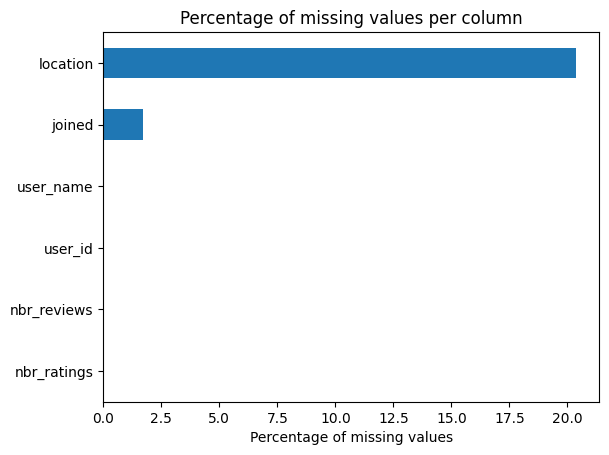

user_name                :     1 missing values (0.00%)
joined                   :  2652 missing values (1.73%)
location                 : 31279 missing values (20.35%)


In [25]:
show_missing(users)

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [26]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

display(users_filtered.sample(3))
print('Shape of users filtered: ', users_filtered.shape)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
78080,2,0,jbinthe615.860968,1.410257e+09,"United States, Virginia"
39393,25,6,avool1960.837547,1.406974e+09,"United States, New Jersey"
137648,1,0,mvanliere.721669,1.362395e+09,"United States, Massachusetts"


Shape of users filtered:  (153704, 5)


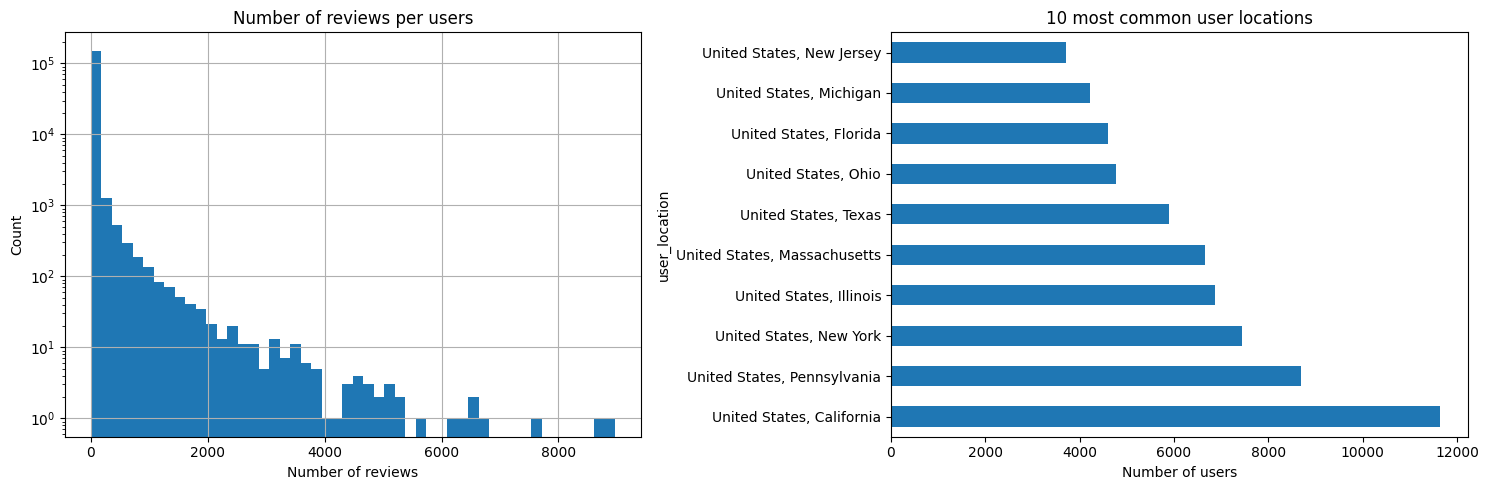

In [27]:
# Representation of reviews per user and most common user locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### 1.2.4 Reviews dataset 📝

In [28]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
957290,Red Cap,82522,Kulshan Brewing Company,28281,American Amber / Red Ale,5.5,1421233200,Moose90,moose90.704894,3.0,2.75,3.0,2.0,2.0,2.34,"A – Pours a deep ruby red hue, foamy tan color..."
1956889,Shipyard Pumpkinhead Ale,1932,Shipyard Brewing Co.,139,Pumpkin Ale,4.7,1191492000,Murchmac,murchmac.64050,3.0,3.50,3.5,3.5,4.0,3.57,This is the light beers of pumpkin beers.Smell...
2116938,Dark Horse Double Crooked Tree IPA,22381,Dark Horse Brewing Company,1471,American Double / Imperial IPA,12.0,1222423200,russpowell,russpowell.19986,4.5,4.50,4.5,4.5,4.5,4.50,"got this one from czoch75, cheers Clint! Pours..."


Shape of reviews :  (2589586, 16)


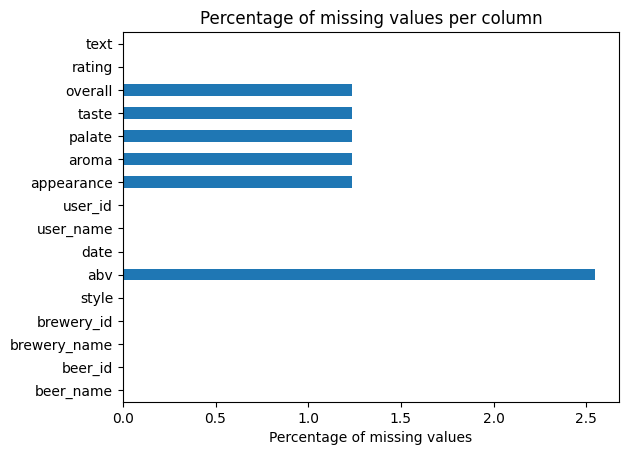

abv                      : 65983 missing values (2.55%)
user_name                :     3 missing values (0.00%)
appearance               : 32009 missing values (1.24%)
aroma                    : 32009 missing values (1.24%)
palate                   : 32009 missing values (1.24%)
taste                    : 32009 missing values (1.24%)
overall                  : 32009 missing values (1.24%)
text                     :     2 missing values (0.00%)


In [29]:
show_missing(reviews)

In [30]:
# making sure that all the missing values of the rating aspects are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
print()
# print the number of rows that contains a NaN value for all the rating aspects
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009

all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [31]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

#remove the two reviews that have no text
reviews_filtered = reviews_filtered[~reviews_filtered['text'].isna()].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
1715030,6260,64,Pumpkin Ale,1349431200,mschind.92124,3.50,4.00,3.50,4.0,4.0,3.92,"This is the 2012 batch of Punk, grabbed a four..."
289007,2011,4686,Märzen / Oktoberfest,1128592800,hardtarget.1712,3.00,3.50,3.00,3.5,4.0,3.52,"Bottle Inspection: Date code, green 12 oz bott..."
2067068,19960,1199,American Double / Imperial Stout,1429524000,navygoat.952085,4.75,4.75,4.75,5.0,5.0,4.90,A friend gave me a bottle of KBS to try; oh bo...


Shape of reviews_filtered :  (2557575, 12)


In [32]:
show_missing(reviews_filtered)

There are no missing values in this dataset.


<div class="alert alert-block alert-danger">
<b>Danger:</b> 
This cell was not executed, in our first serving style extraction, so we need to re-execute it. (for my analysis, I've done it later and reran the cells)
</div>

In [ ]:
# for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
df['beer_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
df['beer_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
df['beer_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
df['beer_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
df['beer_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

df['beer_std'] = df.groupby('beer_id')['overall'].transform('std')
df['beer_std_appearance'] = df.groupby('beer_id')['appearance'].transform('std')
df['beer_std_aroma'] = df.groupby('beer_id')['aroma'].transform('std')
df['beer_std_palate'] = df.groupby('beer_id')['palate'].transform('std')
df['beer_std_taste'] = df.groupby('beer_id')['taste'].transform('std')
df['beer_std_overall'] = df.groupby('beer_id')['overall'].transform('std')

df_initial = df.copy(deep=True)


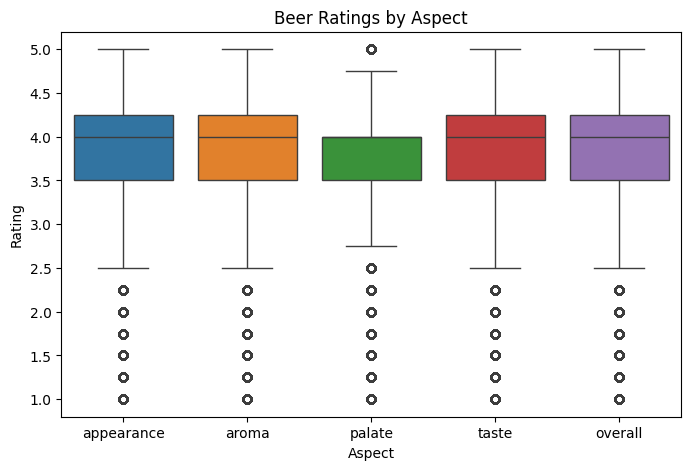

In [33]:
# boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### 1.3 Merge datasets 🔗

In [34]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
2447220,34306,15237,Quadrupel (Quad),1258801200,blackhaddock.90923,4.0,4.0,4.5,4.5,4.5,4.35,"Brown 33cl bottle (2007 version, PNP No4) obta...",2396,839,4.33,10.0,3050,3050,1.154686e+09,England,Belgium,145


Shape of df_merged :  (2557575, 22)


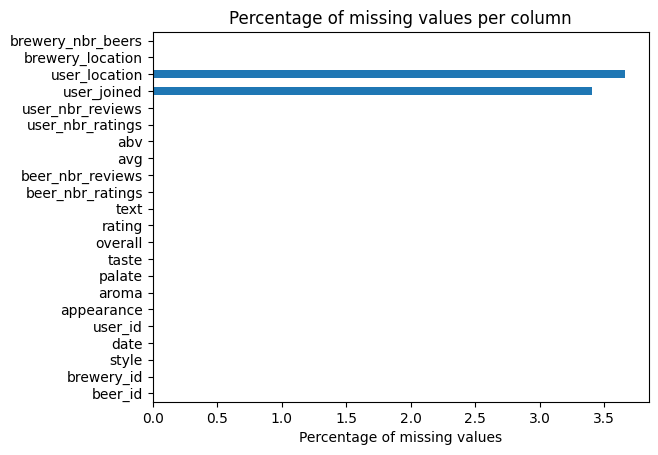

user_joined              : 87150 missing values (3.41%)
user_location            : 93668 missing values (3.66%)


In [35]:
show_missing(df_merged)

In [36]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

> We have an almost complete dataset. Only information about the location of users is missing for 3.66% reviews.

In [37]:
# Save to csv
df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

## 2. Data enrichment 🍺

In [2]:
# load csv from step 1
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [3]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
894325,43889,16866,Berliner Weissbier,1260356400,weeare138.1843,3.5,3.5,3.5,3.5,4.0,3.60,Thanks to hopdog for supplying this...Appears ...,1590,431,4.02,3.1,2887,2491,1.049191e+09,"United States, Pennsylvania","United States, California",734
164829,24910,3716,English India Pale Ale (IPA),1135335600,viggo.6777,4.0,3.0,3.5,3.0,3.0,3.11,"Pours a cloudy orange brown, huge white head f...",22,18,3.47,6.0,2428,2424,1.087207e+09,Canada,Canada,24
1385168,37323,898,Weizenbock,1219226400,patrickjr.213570,3.5,4.5,4.5,4.0,4.0,4.14,Poured from 12 oz bottle into weizen glass.A -...,298,261,3.81,10.0,631,631,1.208772e+09,"United States, North Carolina","United States, Maryland",131


Shape of df :  (2557575, 22)


### 2.1 Serving style 🍾🥤🚰

#### 2.1.1 naive approach

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served.   
A first idea was to use a naive approach. We only look at whether a word specific to as service style has been used. 

In [4]:
def serving_type_naive(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column serving_type_naive that contains the serving type of the beer using the naive approach.

    Parameters:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_naive' column.
    """
    # Create 3 different columns according to the text review, "bottle", "can", "draft"
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans', }
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler', 'keg'}
    
    # Create different columns if review text contains the word
    df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
    df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
    df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))
    
    # Initialize the serving_type_naive column to 'not_set' with dtype str
    df['serving_type_naive'] = 'not_set'
    df['serving_type_naive'] = df['serving_type_naive'].astype(str)
    
    # if there are more than one true or no true, set the value to 'unknown'
    df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'

    # drop the columns bottle, can, and draft
    df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)
    
    return df

#### 2.1.2 Similarity 🍾🥤🚰

> Compute the similarity between the reviews and a list of words specific to each serving style. The list is more exhaustive in this method, using words such as aluminium or cork for can and bottle respectively. Select the serving style with the highest similarity.

In [5]:
def serving_type_sim(df: pd.DataFrame, word_bottle: str = 'data/bottle.txt', word_can: str = 'data/can.txt', word_draft: str = 'data/draft.txt', threshold: float = 0.05) -> pd.DataFrame:
    """
    Compute the cosine similarity between the review text and the list of words for each serving type. 
    Select the serving type with the highest similarity score.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - word_bottle (str): Path to the text file containing words related to 'bottle' serving type.
    - word_can (str): Path to the text file containing words related to 'can' serving type.
    - word_draft (str): Path to the text file containing words related to 'draft' serving type.
    - threshold (float): The threshold for considering a serving type based on cosine similarity.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_sim' column.
    """
    # Read the list of words from the text file
    with open(word_can, 'r') as file:
        word_can = file.read().splitlines()

    with open(word_bottle, 'r') as file:
        word_bottle = file.read().splitlines()

    with open(word_draft, 'r') as file:
        word_draft = file.read().splitlines()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the review and words list using TF-IDF
    tfidf_matrix = vectorizer.fit_transform(df['text'].astype(str))

    can_vector = vectorizer.transform([" ".join(word_can)])
    bottle_vector = vectorizer.transform([" ".join(word_bottle)])
    draft_vector = vectorizer.transform([" ".join(word_draft)])

    # Calculate the cosine similarity
    cosine_sim_can = cosine_similarity(tfidf_matrix, can_vector)
    cosine_sim_bottle = cosine_similarity(tfidf_matrix, bottle_vector)
    cosine_sim_draft = cosine_similarity(tfidf_matrix, draft_vector)

    # Get the maximum similarity score and corresponding serving type
    max_sim = np.maximum.reduce([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft])
    serving_type = np.where(max_sim >= threshold, np.array(['bottle', 'can', 'draft'])[np.argmax([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft], axis=0)], 'unknown')

    # Add the serving_type_sim column to the dataframe
    df['serving_type_sim'] = serving_type

    return df

#### 2.1.3 Rule-based approach 🍾🥤🚰

> Homemade algorithm used to find the serving type using a rule-based approach.

In [6]:
nlp = spacy.load("en_core_web_sm")
from spacy.tokens import Doc

def differentiate_can(doc: Doc) -> List[str]:
    """
    Differentiate between the noun and verb form of the word "can" in the review text.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - List[str]: A list indicating whether each occurrence of "can" is used as a noun or a verb.
    """
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom

def remove_conditional(doc: Doc) -> Doc:
    """
    Remove parts of the review text that are in the conditional form.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - spacy.tokens.Doc: The modified SpaCy Doc object with conditional parts removed.
    """
    modified_tokens = []
    remove_sentence = False

    for sent in doc.sents:
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() in {"would", "could", "'d", "will"}:
                subtree = [t.text for t in token.subtree]
                modified_tokens.extend(subtree[:-1])
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    modified_text = " ".join(modified_tokens)

    return nlp(modified_text)

def extract_serving_style(review: str) -> str:
    """
    Return the serving style of the beer using the rule-based approach.

    Parameters:
    - review (str): The input text of the beer review.

    Returns:
    - str: The serving style of the beer.
    """
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler'}

    modified_doc = remove_conditional(nlp(review))
    #modified_doc = nlp(review)

    serving_styles = set()

    if any(word in modified_doc.text.lower() for word in bottle):
        serving_styles.add("bottle")
    if any(word in modified_doc.text.lower() for word in can) and "noun" in differentiate_can(modified_doc):
        serving_styles.add("can")
    if any(word in modified_doc.text.lower() for word in draft):
        serving_styles.add("draft")

    serving_style = serving_styles.pop() if len(serving_styles) == 1 else 'unknown'

    return serving_style

def process_row(row: pd.Series) -> str:
    """
    Process a row of a DataFrame, extracting the serving style of the beer from the 'text' column.

    Parameters:
    - row (pd.Series): A row of a DataFrame containing a 'text' column.

    Returns:
    - str: The serving style of the beer.
    """
    serving_style = extract_serving_style(row.text)
    return serving_style

def serving_type_rulebased(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the rule-based serving type extraction function to each row of the DataFrame in parallel.

    Parameters:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_rulebased' column.
    """
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

> This function is quite simple and we will try to adapt it further in Milestone P3. On the test performed below on the hand-labeled dataset, we applied this function to extract the serving styles. We first did it without the ```remove_conditional``` function, and it took 2.6s for an accuracy of 91.2%. With the function, it took 4.5s for an accuracy of 91.6%. Therefore, the choice was made to not use the function as it almost doubled runtime.

#### 2.1.4 Test on sample df

<blockquote>

To test which method performed best to retrieve the serving style of a beer, we manually labelled 250 reviews sampled randomly on the merged dataset. Each member of the group labelled 50 reviews as "unknown", "draft", "can" or "bottle".<break>


The goal was to learn more about the reviews, and find pattern that could help us for the rule-based method. After a few reviews, we added some words related to draft for example.


</blockquote>

##### 2.1.4.1 Obtain a df with true serving types

In [ ]:
#250 reviews for function evaluation (manually labelled)
df_eval = df.sample(n=250, random_state=46).copy(deep=True)
df_eval['true_serving_type'] = 'not_set'

In [ ]:
df_eval['true_serving_type'].value_counts()

true_serving_type
not_set    250
Name: count, dtype: int64

In [ ]:
# Function used to display a review and label the serving style
#idx = display_review(df_eval)
#df_eval = update_review_serving_type(df_eval, idx)

In [ ]:
# df_eval.to_csv('data/BeerAdvocateEval.csv', index=False)
df_eval = pd.read_csv('data/BeerAdvocateEval.csv')

In [ ]:
# Distribution of the serving types in the evaluation set
df_eval['true_serving_type'].value_counts()

true_serving_type
unknown    141
bottle      82
draft       20
can          7
Name: count, dtype: int64

##### 2.1.4.2 Call each function and evaluate (time and accuracy)

In [ ]:
display(df_eval.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,true_serving_type
187,64220,6288,American Wild Ale,1346407200,viciousknishs.401136,3.5,3.5,4.0,4.0,3.5,3.75,A- pours a murky brown with a tan head.S- smel...,59,22,3.73,5.2,390,320,1.260097e+09,"United States, Virginia",Belgium,132,unknown
85,299,96,Fruit / Vegetable Beer,1290855600,leokbelo.88223,4.5,4.0,3.0,3.5,4.5,3.83,Pours a hazy copper with a 1 1/2 inch foamy he...,5692,1703,3.40,5.1,146,87,1.152698e+09,"United States, Florida","United States, Vermont",139,unknown
156,42312,10321,American Pale Ale (APA),1344938400,smakawhat.204323,3.5,2.0,3.0,3.5,2.0,2.79,Poured from the can into a nonic pint glass. U...,215,120,3.80,5.0,3950,3869,1.205838e+09,"United States, Maryland",Canada,120,can


In [ ]:
t1 = time.time()
df_eval = serving_type_naive(df_eval)
t_naive = time.time() - t1
print(f"Naive method took {t_naive} seconds")

print('Naive method accuracy:', compute_accuracy(df_eval['serving_type_naive'], df_eval['true_serving_type']))

NameError: name 'time' is not defined

In [ ]:
t1 = time.time()
df_eval = serving_type_sim(df_eval, threshold=0.03)
t_sim = time.time() - t1
print(f"Similarity method took {t_sim} seconds")

print('Similarity method accuracy:', compute_accuracy(df_eval['serving_type_sim'], df_eval['true_serving_type']))

Similarity method took 0.04380178451538086 seconds
correct_count: 161, total_count: 250
Similarity method accuracy: 0.644


In [ ]:
t1 = time.time()
df_eval = serving_type_rulebased(df_eval)
t_rulebased = time.time() - t1
print(f"Rulebased method took {t_rulebased} seconds")

print('Rulebased method accuracy:', compute_accuracy(df_eval['serving_type_rulebased'], df_eval['true_serving_type']))

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:17<00:00, 14.16it/s]

Rulebased method took 17.729158401489258 seconds
correct_count: 228, total_count: 250
Rulebased method accuracy: 0.912


In [ ]:
#print one random misidentified review
df_misclassified = df_eval[df_eval['serving_type_rulebased'] != df_eval['true_serving_type']].copy(deep=True)
for index, row in df_misclassified.sample(22).iterrows():
    print(f"Review {index}:\n{row['text']}\nRule-based serving type: {row['serving_type_rulebased']}\nTrue serving type: {row['true_serving_type']}\n")
    print(differentiate_can(nlp(row['text'])))

NameError: name 'df_eval' is not defined

> It is quite clear that the rulebased method is the best one. It takes longer to run, but the accuracy gain is worth it. We will use this method to classify the reviews between the 3 serving styles. By exploring the reviews that get classified as ```unknown``` we realize that the main reason is that they contain two or more serving styles, so in Milestone P3 our objective is to adapt further the classification to solve this problem. An idea could be to perform a temporal analysis or to use the ```remove_conditional``` function. However, this will negatively impact run time.

In [ ]:
# Classification of serving type on the whole dataset
#### 8h run-time
# df = serving_type_rulebased(df)
df = pd.read_csv(dataset_path + 'BA_classified.csv')

In [ ]:
# # for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
# df['beer_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
# df['beer_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
# df['beer_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
# df['beer_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
# df['beer_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

# df['beer_std'] = df.groupby('beer_id')['overall'].transform('std')
# df['beer_std_appearance'] = df.groupby('beer_id')['appearance'].transform('std')
# df['beer_std_aroma'] = df.groupby('beer_id')['aroma'].transform('std')
# df['beer_std_palate'] = df.groupby('beer_id')['palate'].transform('std')
# df['beer_std_taste'] = df.groupby('beer_id')['taste'].transform('std')
# df['beer_std_overall'] = df.groupby('beer_id')['overall'].transform('std')

# df_initial = df.copy(deep=True)

> The extraction took 14h on a recent MacAir with an 8 cores CPU. With our previous estimations on run time, using the ```remove_conditional``` function would have taken 30h. We will try to adapt the function ```extract_serving_style``` by adding new rules, based on the different tenses of the sentences. As explained before, there is a big potential to reduce less the dataset (have less 'unknown' samples) if we manage to extract the style in reviews which have 2 serving styles present. Therefore, we know for a fact that these reviews contain the true serving style, which we will try to retrieve. The additional rules that we plan to use based on the tense of the sentences will probably increase this number a lot too, so we might need to use an online GPU solution.

In [ ]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,beer_avg_appearance,beer_avg_aroma,beer_avg_palate,beer_avg_taste,beer_avg_overall,beer_std,beer_std_appearance,beer_std_aroma,beer_std_palate,beer_std_taste,beer_std_overall
514422,62984,2372,Milk / Sweet Stout,1290596400,thedoubler55.447595,4.5,4.0,3.5,3.5,3.5,3.68,"A- Very dark chocolate body with a tan head, l...",2541,626,3.94,6.0,417,417,1.270980e+09,"United States, New Jersey","United States, Georgia",183,unknown,3.912379,3.866961,3.875804,3.981511,3.975080,0.498974,0.442962,0.488068,0.570819,0.473386,0.498974
2188111,198,63,American Porter,1098266400,guinnesssmurf.2417,4.0,4.0,3.0,4.0,3.5,3.80,Appearance: darkest brown body with a nice rub...,6100,1563,4.16,5.2,229,229,1.057745e+09,"United States, Missouri","United States, Oregon",431,unknown,4.115846,4.052981,4.045690,4.203176,4.243519,0.465186,0.437468,0.458814,0.520902,0.472186,0.465186
2527656,7901,152,English Pale Ale,1131447600,dogfood11.23406,3.5,3.5,4.5,4.0,4.0,3.90,First time I'd seen this at my local beer stor...,94,90,3.76,4.3,1196,1196,1.118830e+09,NaN,"United Kingdom, England",17,unknown,3.883333,3.600000,3.761111,3.783333,3.961111,0.546839,0.424330,0.525742,0.469447,0.443746,0.546839


Shape of df :  (2557575, 34)


### 2.2 Data filtering 🧹
Since our analysis will be focused on the serving style, we will remove all reviews where no serving style was identified. 

<div class="alert alert-block alert-warning">
<b>Alert:</b> By doing so, we are reducing our dataset by more than half. We will need to check if our dataset is still representative of the initial one. 
</div>

In [ ]:
# count the number of reviews for each serving_type_rulebased
print(df['serving_type_rulebased'].value_counts(normalize=False))

# percentage of unknown serving type
print('Percentage of unknown serving type:', round(df['serving_type_rulebased'].value_counts(normalize=True)['unknown']*100, 2), '%')

serving_type_rulebased
unknown    1473892
bottle      780261
draft       245501
can          57921
Name: count, dtype: int64
Percentage of unknown serving type: 57.63 %


In [ ]:
# drop rows where serving_type_rulebased is unknown
df = df[df['serving_type_rulebased'] != 'unknown'].copy(deep=True)

### 2.3 Sentiment analysis 📝

<blockquote>

In this part of the notebook, we tried to assess whether a review was on the positive or negative side with a polarity analysis. We also looked at subjectivity.
If a serving style appears to have statistically higher ratings than another, we could look if the polarity of the reviews reaches the same conclusion.

</blockquote>

In [ ]:
#df = sentiment_analysis(df)
#df.to_csv(dataset_path + 'BA_sentiment.csv', index=False)
df = pd.read_csv(dataset_path + 'BA_sentiment.csv')

In [ ]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity
1050583,27226,10557,Witbier,1209290400,ccrida.80807,4.0,4.0,4.0,4.5,4.5,4.30,750 ml bottle dated 12 May 07 on the wrapper (...,136,70,4.02,7.0,2242,2203,1.148638e+09,"United States, Oregon",Belgium,26,bottle,0.228074,0.526641
158874,1402,184,Quadrupel (Quad),1132916400,canucklehead.1700,4.5,4.0,4.0,4.5,4.0,4.23,The last time this beer was available in BC it...,2333,948,4.12,10.0,1780,1646,1.047035e+09,Canada,Netherlands,20,bottle,0.255952,0.408333
702175,21466,64,Fruit / Vegetable Beer,1312797600,oline73.371504,3.5,3.0,4.0,4.0,3.5,3.63,Poured from a bottle into a snifter. This was ...,1297,564,3.68,18.0,6302,1511,1.253268e+09,"United States, Maryland","United States, Delaware",378,bottle,0.184861,0.502778


Shape of df :  (1083683, 25)


### 2.4 Readability score 📖

> In this step, we checked the readability score of the review. This might not be necessary but it was still interesting to compare which ratings had higher readability score.

In [ ]:
#df = compute_readability(df)
#df.to_csv(dataset_path + 'BA_readability.csv', index=False)
df = pd.read_csv(dataset_path + 'BA_readability.csv')

In [ ]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,beer_std,beer_avg_appearance,beer_avg_aroma,beer_avg_palate,beer_avg_taste,beer_avg_overall
660582,34129,140,American Barleywine,1459764000,stratusjeans.876334,4.25,4.25,4.25,4.25,4.25,4.25,'14 version on tap at Brouwers.Just has the '1...,1310,258,4.14,12.2,354,55,1.413022e+09,"United States, Washington","United States, California",574,draft,0.419234,4.117126,4.159449,4.086614,4.145669,4.127953
275794,15538,890,Rauchbier,1076756400,globetrotter.1845,4.00,4.00,3.50,4.00,4.00,3.95,Comes in a heavy brown half-liter bottle with ...,2,2,3.88,4.9,1170,1170,1.049278e+09,"United States, Virginia",Germany,55,bottle,0.353553,3.750000,4.000000,3.500000,4.000000,3.750000
236582,62955,37503,Saison / Farmhouse Ale,1337248800,doodler.382642,4.50,4.00,4.00,4.50,4.50,4.33,Got to try a bottle at Nørrebro Bryghus in Cop...,16,12,4.41,6.5,166,71,1.255774e+09,"United States, Colorado",Denmark,54,bottle,0.464660,4.270833,4.479167,4.354167,4.375000,4.500000


Shape of df :  (1083683, 29)


### 2.5 Metrics udpdate 📊

> The metrics updated in this step will be compared with the previous ones (user_nbr_reviews, beer_nbr_reviews, avg). Since our dataset has been reduced by half, approximately half of the reviews were lost. We will check if our final dataset is still representative of the initial one by comparing the average rating of a beer before and after the filtering. 

In [ ]:
# compute the number of valid reviews per user
df['user_filtered_nbr_reviews'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_filtered_nbr_reviews'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_filtered_avg'] = df.groupby('beer_id')['rating'].transform('mean')
df['beer_filtered_std'] = df.groupby('beer_id')['rating'].transform('std')

In [ ]:
# for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
df['beer_filtered_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
df['beer_filtered_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
df['beer_filtered_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
df['beer_filtered_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
df['beer_filtered_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

df['beer_filtered_std_appearance']= df.groupby('beer_id')['appearance'].transform('std')
df['beer_filtered_std_aroma']= df.groupby('beer_id')['aroma'].transform('std')
df['beer_filtered_std_palate']= df.groupby('beer_id')['palate'].transform('std')
df['beer_filtered_std_taste']= df.groupby('beer_id')['taste'].transform('std')
df['beer_filtered_std_overall']= df.groupby('beer_id')['overall'].transform('std')


In [ ]:
# df.to_csv(dataset_path + 'BA_enriched.csv', index=False)
df = pd.read_csv(dataset_path + 'BA_enriched.csv')

In [ ]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity,readability_score,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed
310563,103604,1337,American IPA,1391684400,rawfish.536519,4.5,4.0,3.0,3.50,3.50,3.63,"Pours corn yellow from the can, mild chill haz...",397,59,3.96,4.5,2074,674,1.291892e+09,"United States, California","United States, California",608,can,0.109848,0.620909,80.11,181,17,3.831176
442733,101919,26520,American Barleywine,1382263200,jaasen64.654800,4.0,4.0,4.5,4.25,4.25,4.20,"500ml bottle picked up at the brewery today, p...",350,42,4.25,14.0,1239,693,1.326625e+09,"United States, Massachusetts","United States, Massachusetts",197,bottle,0.270037,0.581765,66.57,590,22,4.251818
689599,43132,141,Belgian Pale Ale,1251540000,blackbearforge.170636,4.0,4.0,4.0,4.00,4.00,4.00,Bottle says best before Dec. '09Pours a mice g...,625,323,3.46,4.7,309,309,1.194433e+09,"United States, Florida","United States, New Hampshire",182,bottle,0.298501,0.568633,74.59,97,136,3.501691


Shape of df :  (1083683, 29)


### 2.6 Countries grouping 🌍

In [ ]:
# Group the countries by world region
countries = pd.read_csv('data/countries_region.csv')[['name', 'sub-region']]
countries.sample(3)

,name,sub-region
12,Aruba,Latin America and the Caribbean
242,Virgin Islands (British),Latin America and the Caribbean
75,Finland,Northern Europe


In [ ]:
# add a column user_country with the country of the user
df['user_location'] = df['user_location'].fillna('Unknown')
df['user_country'] = df['user_location'].apply(lambda x: 'United States of America' if 'United States, ' in x else x)

df.sample(1)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity,readability_score,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed,user_country
51155,30947,1141,Herbed / Spiced Beer,1237719600,barflyb.181122,4.0,4.0,4.0,4.0,4.0,4.0,11.5oz bottle into a La Choulette glass. Thank...,774,388,3.82,5.9,3139,1576,1.198321e+09,"United States, Pennsylvania",Canada,242,bottle,0.243444,0.532214,85.49,1199,147,3.710068,United States of America


In [ ]:
# rename or add country with names different than in user_country

# rename the column of countries that cause problems 
def rename_countries(old_name, new_name):
    countries['name'] = countries['name'].replace(old_name, new_name)
    return

rename_countries('Bolivia (Plurinational State of)', 'Bolivia')
rename_countries('Tanzania, United Republic of', 'Tanzania')
rename_countries('South Georgia and the South Sandwich Islands', 'South Georgia and South Sandwich Islands')
rename_countries('Fiji', 'Fiji Islands')
rename_countries('New Zealand', 'Aotearoa')
rename_countries('Taiwan, Province of China', 'Taiwan')
rename_countries('North Macedonia', 'Macedonia')
rename_countries('Viet Nam', 'Vietnam')
rename_countries('Russian Federation', 'Russia')
rename_countries('Czechia', 'Czech Republic')
rename_countries('Slovakia', 'Slovak Republic')
rename_countries('Svalbard and Jan Mayen', 'Svalbard and Jan Mayen Islands')

new_countries = pd.DataFrame({'name': ['England', 'Wales', 'Northern Ireland', 'Scotland', 'Unknown'], 'sub-region': ['Northern Europe','Northern Europe','Northern Europe','Northern Europe', 'Unknown']})

countries = pd.concat([countries, new_countries]).drop_duplicates().reset_index(drop=True)

In [ ]:
# add column user_subregion to df
df = df.merge(countries[['name', 'sub-region']], left_on='user_country', right_on='name', how='left')
df.rename(columns={'sub-region': 'user_subregion'}, inplace=True)
df = df.drop(columns=['name'])

df.sample(5)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity,readability_score,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed,user_country,user_subregion
456944,2163,45,Dubbel,1107082800,beergeek279.1967,4.5,4.00,4.0,4.5,4.0,4.23,Served from a 64 oz. growler (purchased at Fat...,12,12,4.08,8.5,717,717,1.051265e+09,"United States, Pennsylvania","United States, New York",181,draft,0.223194,0.527743,80.41,522,5,4.226000,United States of America,Northern America
690922,188881,30697,Russian Imperial Stout,1449313200,jdhilt.84,4.5,3.75,4.0,4.0,4.0,3.97,Pours a four-finger light tan head that fades ...,35,12,4.33,10.5,2915,2852,9.972648e+08,"United States, New Hampshire","United States, New Hampshire",23,bottle,0.180741,0.542963,79.46,2496,9,4.300000,United States of America,Northern America
85197,7728,697,Belgian Strong Dark Ale,1294743600,bsp77.215044,4.0,4.00,4.5,4.5,4.5,4.35,Serving glass: Poured from bottle into Pilsner...,732,365,3.78,8.0,1423,1416,1.209290e+09,"United States, Minnesota",Japan,45,bottle,0.309333,0.619000,53.68,1139,160,3.793750,United States of America,Northern America
418296,47360,35,Russian Imperial Stout,1234609200,alcahuetej.386983,4.5,4.00,4.5,4.0,3.5,3.98,A - Poured into a Duvel tulip. One-inch tan co...,1495,806,3.82,9.2,28,24,1.102158e+09,"United States, Massachusetts","United States, Massachusetts",285,bottle,0.036344,0.522589,85.99,12,280,3.820250,United States of America,Northern America
554006,54177,158,Old Ale,1268305200,srandycarter.91008,3.0,4.00,4.0,4.0,3.5,3.84,"352/492 bottles.A - Very dark cola, almost bla...",336,97,4.00,12.4,1606,1593,1.154686e+09,"United States, California","United States, Colorado",148,bottle,0.150889,0.540222,90.26,171,62,3.962419,United States of America,Northern America


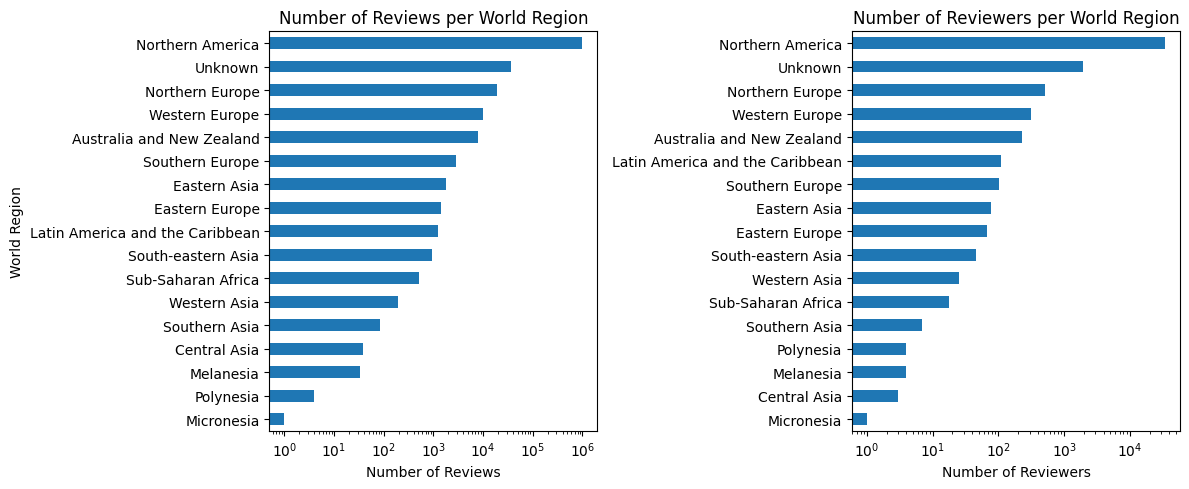

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the number of reviews per world region
df.user_subregion.value_counts().sort_values().plot(kind='barh', ax=ax1)
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('World Region')
ax1.set_title('Number of Reviews per World Region')
ax1.set_xscale('log')

# Plot the number of reviewers per world region
df.groupby('user_subregion')['user_id'].nunique().sort_values().plot(kind='barh', ax=ax2)
ax2.set_xlabel('Number of Reviewers')
ax2.set_ylabel('')  # Hide the y-label
ax2.set_title('Number of Reviewers per World Region')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
# add column with US state for USA users and NaN for others
df['user_US_state'] = df['user_location'].apply(lambda x: x.split(', ')[1] if 'United States' in x else np.nan)
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity,readability_score,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed,user_country,user_subregion,user_US_state
646924,9478,26,American Pale Wheat Ale,1120730400,beerfink.11223,4.50,4.0,4.5,4.5,4.5,4.38,"Decanted from a bomber, this ale showcases a l...",5828,1558,4.21,5.6,180,180,1.101899e+09,"United States, Ohio","United States, Indiana",333,bottle,0.181852,0.464630,75.30,50,648,4.218164,United States of America,Northern America,Ohio
724953,2233,467,Winter Warmer,1347876000,nilocrellim.694788,3.25,3.5,3.0,3.5,3.5,3.44,"Beer came on-tap in a tall glass, and appeared...",572,277,3.72,6.1,1223,708,1.347876e+09,"United States, Minnesota","United States, Minnesota",80,draft,0.146042,0.334583,82.85,180,87,3.724598,United States of America,Northern America,Minnesota
711095,49838,64,American Double / Imperial IPA,1270461600,urwithdave.222592,4.00,4.0,4.0,4.0,4.0,4.00,Poured into a cigar city snifter.A- Golden ora...,1482,795,4.09,9.0,218,158,1.211710e+09,"United States, Florida","United States, Delaware",378,bottle,0.329487,0.652991,89.04,75,459,4.065708,United States of America,Northern America,Florida


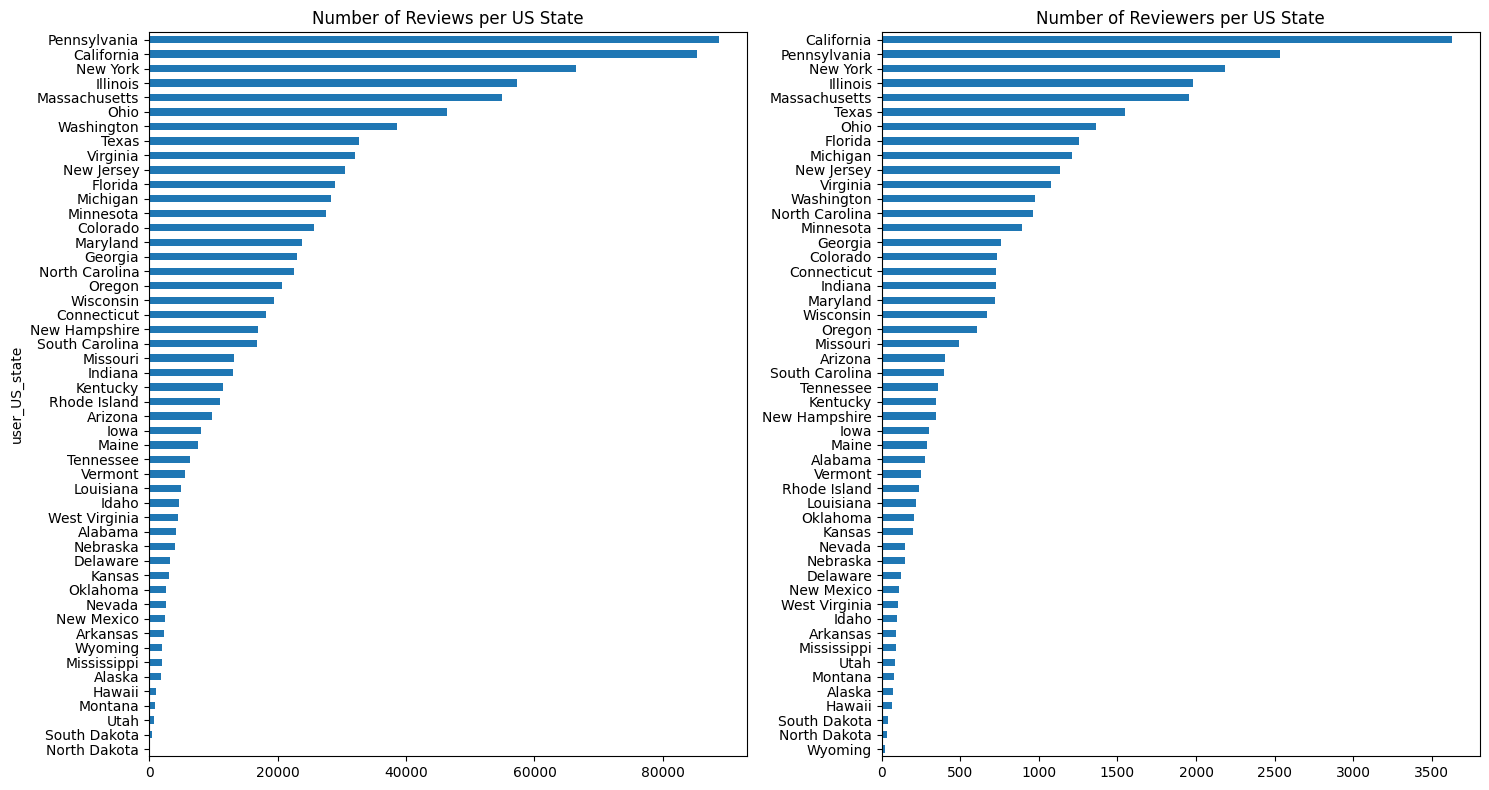

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Number of reviews per US state
df.user_US_state.value_counts().sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Number of Reviews per US State')

# Number of reviewers per US state
df.groupby('user_US_state')['user_id'].nunique().sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Number of Reviewers per US State')
ax2.set_ylabel('')  # Hide the y-label

plt.tight_layout()
plt.show()

### 2.7 Beer styles grouping 🍻

In [ ]:
# Group the beers by more general beer styles
for beer_style in sorted(df['style'].unique()):
    print(beer_style)

Altbier
American Adjunct Lager
American Amber / Red Ale
American Amber / Red Lager
American Barleywine
American Black Ale
American Blonde Ale
American Brown Ale
American Dark Wheat Ale
American Double / Imperial IPA
American Double / Imperial Pilsner
American Double / Imperial Stout
American IPA
American Malt Liquor
American Pale Ale (APA)
American Pale Lager
American Pale Wheat Ale
American Porter
American Stout
American Strong Ale
American Wild Ale
Baltic Porter
Belgian Dark Ale
Belgian IPA
Belgian Pale Ale
Belgian Strong Dark Ale
Belgian Strong Pale Ale
Berliner Weissbier
Bière de Champagne / Bière Brut
Bière de Garde
Black & Tan
Bock
Braggot
California Common / Steam Beer
Chile Beer
Cream Ale
Czech Pilsener
Doppelbock
Dortmunder / Export Lager
Dubbel
Dunkelweizen
Eisbock
English Barleywine
English Bitter
English Brown Ale
English Dark Mild Ale
English India Pale Ale (IPA)
English Pale Ale
English Pale Mild Ale
English Porter
English Stout
English Strong Ale
Euro Dark Lager
Euro Pal

In [70]:
# Define the beer style groups
beer_groups = {
    # Ales
    'American Pale Ale (APA)': 'Ales',
    'American Amber / Red Ale': 'Ales',
    'American Brown Ale': 'Ales',
    'American Blonde Ale': 'Ales',
    'American IPA': 'Ales',
    'American Wild Ale': 'Ales',
    'Belgian Pale Ale': 'Ales',
    'Belgian Strong Pale Ale': 'Ales',
    'Belgian Dark Ale': 'Ales',
    'Belgian IPA': 'Ales',
    'Bière de Garde': 'Ales',
    'English Bitter': 'Ales',
    'English Pale Ale': 'Ales',
    'English Porter': 'Ales',
    'Extra Special / Strong Bitter (ESB)': 'Ales',
    'Irish Red Ale': 'Ales',
    'Scottish Ale': 'Ales',
    'Scottish Gruit / Ancient Herbed Ale': 'Ales',

    # Stouts
    'American Stout': 'Stouts',
    'Irish Dry Stout': 'Stouts',
    'American Double / Imperial Stout': 'Stouts',
    'Russian Imperial Stout': 'Stouts',

    # Lagers
    'American Adjunct Lager': 'Lagers',
    'American Pale Lager': 'Lagers',
    'American Amber / Red Lager': 'Lagers',
    'California Common / Steam Beer': 'Lagers',
    'Dortmunder / Export Lager': 'Lagers',
    'Euro Dark Lager': 'Lagers',
    'Euro Pale Lager': 'Lagers',
    'Euro Strong Lager': 'Lagers',
    'Munich Dunkel Lager': 'Lagers',
    'Munich Helles Lager': 'Lagers',
    'Märzen / Oktoberfest': 'Lagers',
    'Schwarzbier': 'Lagers',
    'Vienna Lager': 'Lagers',
    
    # Strong Ales
    'American Barleywine': 'Strong Ales',
    'Belgian Strong Dark Ale': 'Strong Ales',
    'Belgian Quadrupel (Quad)': 'Strong Ales',
    'English Barleywine': 'Strong Ales',
    'American Double / Imperial IPA': 'Strong Ales',
    'American Double / Imperial Pilsner': 'Strong Ales',
    'American Strong Ale': 'Strong Ales',
    'Eisbock': 'Strong Ales',
    'Old Ale': 'Strong Ales',
    'Wheatwine': 'Strong Ales',
    
    # Wheat Beers
    'American Dark Wheat Ale': 'Wheat Beers',
    'Dunkelweizen': 'Wheat Beers',
    'Hefeweizen': 'Wheat Beers',
    'Kristalweizen': 'Wheat Beers',
    'Weizenbock': 'Wheat Beers',
    'Witbier': 'Wheat Beers',
    'Berliner Weissbier': 'Wheat Beers',
    
    # Specialty and Unique Beers
    'Bière de Champagne / Bière Brut': 'Specialty and Unique Beers',
    'Chile Beer': 'Specialty and Unique Beers',
    'Fruit / Vegetable Beer': 'Specialty and Unique Beers',
    'Herbed / Spiced Beer': 'Specialty and Unique Beers',
    'Pumpkin Ale': 'Specialty and Unique Beers',
    'Rauchbier': 'Specialty and Unique Beers',
    'Roggenbier': 'Specialty and Unique Beers',
    'Sahti': 'Specialty and Unique Beers',
    'Smoked Beer': 'Specialty and Unique Beers',
    
    # Seasonal and Celebration Beers
    'Bock': 'Seasonal and Celebration Beers',
    'Doppelbock': 'Seasonal and Celebration Beers',
    'Maibock / Helles Bock': 'Seasonal and Celebration Beers',
    'Winter Warmer': 'Seasonal and Celebration Beers',
    'Christmas/Winter Specialty Spiced Beer': 'Seasonal and Celebration Beers',
    
    # Sour Beers
    'Flanders Oud Bruin': 'Sour Beers',
    'Flanders Red Ale': 'Sour Beers',
    'Gose': 'Sour Beers',
    'Gueuze': 'Sour Beers',
    'Lambic - Fruit': 'Sour Beers',
    'Lambic - Unblended': 'Sour Beers',
    
    # Historical and Traditional Beers
    'Braggot': 'Historical and Traditional Beers',
    'Happoshu': 'Historical and Traditional Beers',
    'Kellerbier / Zwickelbier': 'Historical and Traditional Beers',
    'Kvass': 'Historical and Traditional Beers',
    'Scotch Ale / Wee Heavy': 'Historical and Traditional Beers',
    'Tripel': 'Historical and Traditional Beers',
    'Japanese Rice Lager': 'Historical and Traditional Beers',
}

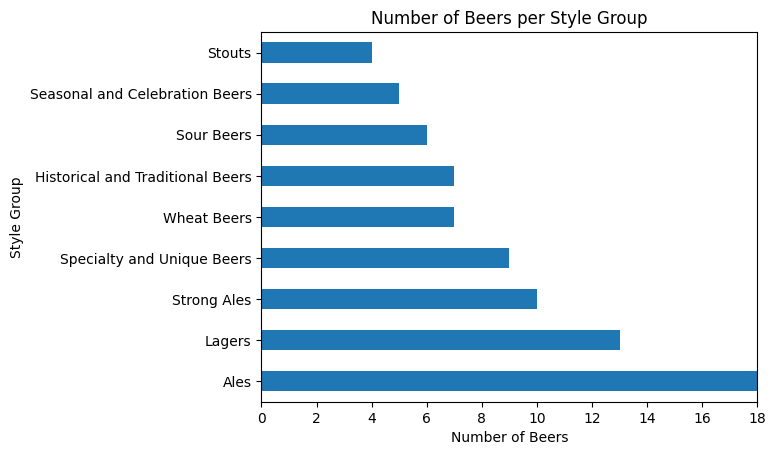

In [71]:
# Count the number of beers in each group and make a bar plot
beer_groups_df = pd.DataFrame.from_dict(beer_groups, orient='index', columns=['group'])
beer_groups_df['group'].value_counts().plot(kind='barh')
plt.title('Number of Beers per Style Group')
plt.xlim(0, 18)
plt.xlabel('Number of Beers')
plt.ylabel('Style Group')
plt.show()



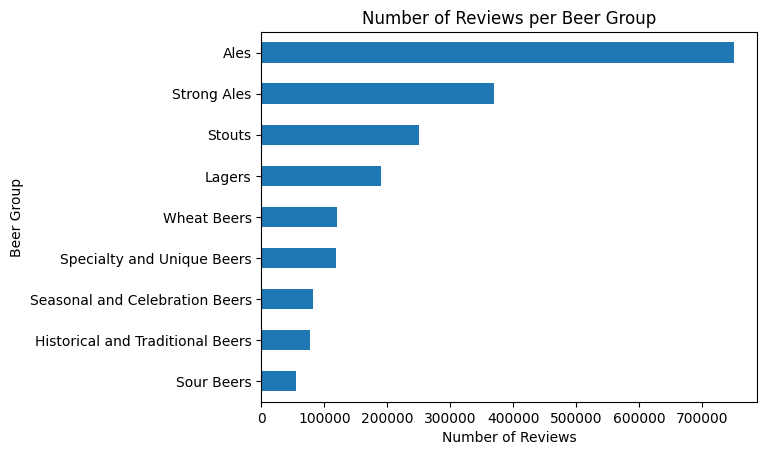

In [72]:
# Plot the number of reviews per beer group
df['beer_group'] = df['style'].map(beer_groups)
df['beer_group'].value_counts().sort_values().plot(kind='barh')
plt.xlabel('Number of Reviews')
plt.ylabel('Beer Group')
plt.title('Number of Reviews per Beer Group')
plt.show()

In [73]:
display(df.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_group
518822,21950,2372,American Double / Imperial Stout,1293793200,jc85.502356,4.5,4.5,4.5,4.5,4.5,4.50,Poured from a 12oz bottle into a pint glass.Ap...,3946,1308,4.25,9.4,22,18,1.284286e+09,"United States, Virginia","United States, Georgia",183,Stouts
55619,19275,798,English Pale Ale,1124100000,whartontallboy.11695,2.5,3.0,3.0,3.0,3.5,3.07,Pours out clear yellow with a thin fizzy head....,70,65,3.50,4.8,1855,379,1.102676e+09,"United States, New York",England,17,Ales
2152804,6314,132,Euro Pale Lager,1277805600,david18.40246,4.0,3.5,4.0,4.0,4.0,3.88,I got this because I had never had this beer b...,710,408,3.59,5.0,1689,942,1.127038e+09,"United States, New York","United States, Oregon",247,Lagers


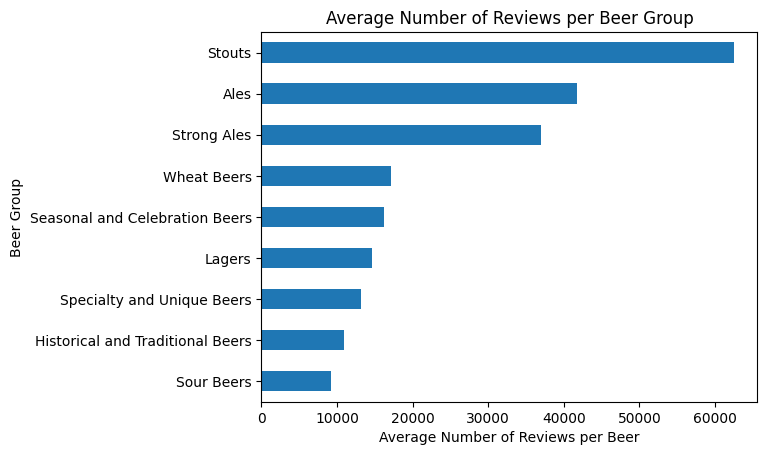

In [75]:
# Calculate the average number of reviews per beer group
average_reviews_per_group = df['beer_group'].value_counts().sort_values() / beer_groups_df['group'].value_counts()

# Plot the average number of reviews per beer group
average_reviews_per_group.sort_values().plot(kind='barh')
plt.xlabel('Average Number of Reviews per Beer')
plt.ylabel('Beer Group')
plt.title('Average Number of Reviews per Beer Group')
plt.show()


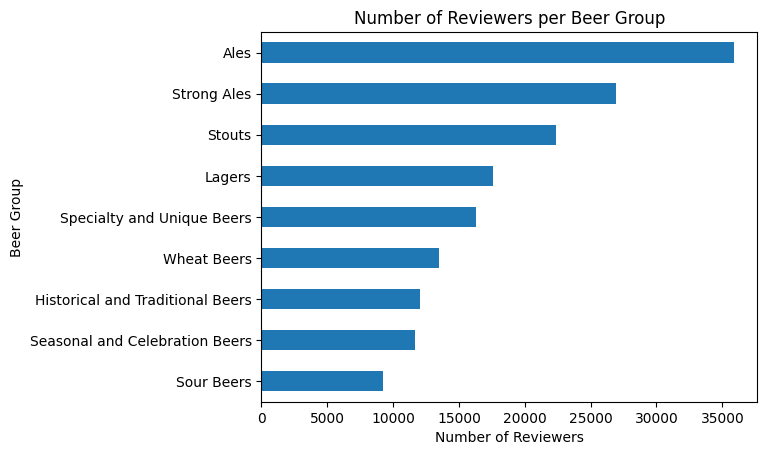

In [15]:
# Plot the number of reviewers per beer group
df.groupby('beer_group')['user_id'].nunique().sort_values().plot(kind='barh')
plt.xlabel('Number of Reviewers')
plt.ylabel('Beer Group')
plt.title('Number of Reviewers per Beer Group')
plt.show()

## 3. Check representation of dataset

In [8]:
# load the filtered dataset
filtered_df = df.copy(deep=True)
# filter per beer id and keep only the columns witg reviews, avg, std, or the words appearance, aroma, palate, taste, overall at the end
#list of columns to keep
columns_beer = ['serving_type_rulebased', 'beer_nbr_reviews', 'beer_filtered_nbr_reviews',
                'avg', 'beer_avg_appearance', 'beer_avg_aroma', 'beer_avg_palate', 'beer_avg_taste', 'beer_avg_overall',
                'beer_std', 'beer_std_appearance', 'beer_std_aroma', 'beer_std_palate', 'beer_std_taste', 'beer_std_overall',
                'beer_filtered_nbr_reviews','beer_filtered_avg', 'beer_filtered_std',
                'beer_filtered_avg_appearance', 'beer_filtered_avg_aroma', 'beer_filtered_avg_palate', 'beer_filtered_avg_taste', 'beer_filtered_avg_overall',
                'beer_filtered_std_appearance', 'beer_filtered_std_aroma', 'beer_filtered_std_palate', 'beer_filtered_std_taste', 'beer_filtered_std_overall',
                ]

columns_user = ['user_nbr_reviews', 'user_filtered_nbr_reviews']

# Group by beer_id and user_id and perform aggregation
filtered_df_beer = filtered_df.groupby('beer_id').agg({col: 'first' for col in columns_beer})
filtered_df_user = filtered_df.groupby('user_id').agg({col: 'first' for col in columns_user})

In [14]:
display(filtered_df_beer)

,serving_type_rulebased,beer_nbr_reviews,beer_filtered_nbr_reviews,avg,beer_avg_appearance,beer_avg_aroma,beer_avg_palate,beer_avg_taste,beer_avg_overall,beer_std,beer_std_appearance,beer_std_aroma,beer_std_palate,beer_std_taste,beer_std_overall,beer_filtered_avg,beer_filtered_std,beer_filtered_avg_appearance,beer_filtered_avg_aroma,beer_filtered_avg_palate,beer_filtered_avg_taste,beer_filtered_avg_overall,beer_filtered_std_appearance,beer_filtered_std_aroma,beer_filtered_std_palate,beer_filtered_std_taste,beer_filtered_std_overall
beer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,bottle,10,6,3.64,3.950000,3.800000,3.700000,3.450000,3.700000,0.674949,0.643342,0.586894,0.752773,0.831665,0.674949,3.530000,0.540629,3.666667,3.583333,3.833333,3.333333,3.666667,0.605530,0.584523,0.258199,0.752773,0.516398
5,bottle,543,163,3.40,3.524674,3.239758,3.342644,3.379423,3.525605,0.629218,0.551432,0.589188,0.624931,0.626498,0.629218,3.381840,0.528086,3.549080,3.268405,3.334356,3.363497,3.526074,0.559609,0.613982,0.595910,0.626204,0.631365
6,bottle,1019,305,3.64,3.843287,3.537019,3.537759,3.653258,3.697187,0.585922,0.449730,0.542863,0.550551,0.538438,0.585922,3.584328,0.468219,3.842623,3.445082,3.502459,3.624590,3.632787,0.442206,0.551665,0.566138,0.590190,0.633812
7,draft,811,241,3.20,3.297188,3.212500,3.158437,3.133750,3.278125,0.774065,0.639154,0.698089,0.677024,0.727124,0.774065,3.193112,0.597707,3.296680,3.161826,3.184647,3.152490,3.283195,0.654432,0.697283,0.633388,0.699206,0.767801
8,draft,72,32,3.27,3.277778,3.055556,3.291667,3.215278,3.569444,0.857057,0.610293,0.647615,0.659439,0.701238,0.857057,3.268438,0.604697,3.265625,3.140625,3.250000,3.187500,3.593750,0.647382,0.650488,0.683917,0.704250,0.827331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293255,draft,1,1,3.83,4.000000,4.000000,3.750000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,3.830000,NaN,4.000000,4.000000,3.750000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN
293261,draft,1,1,3.67,3.750000,3.500000,3.500000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,3.670000,NaN,3.750000,3.500000,3.500000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN
293264,draft,1,1,4.23,4.250000,4.250000,4.000000,4.250000,4.250000,NaN,NaN,NaN,NaN,NaN,NaN,4.230000,NaN,4.250000,4.250000,4.000000,4.250000,4.250000,NaN,NaN,NaN,NaN,NaN


In [16]:
display(filtered_df_user)

,user_nbr_reviews,user_filtered_nbr_reviews
user_id,,
--dom--.709199,53,30
--weezl--.789708,3,2
-blast-tyrant-.1105240,1,1
-rick.912339,194,52
-royce-.998082,1,1
...,...,...
zythophile.1101219,184,136
zythus.301538,8,4
zz427.1113802,2,2


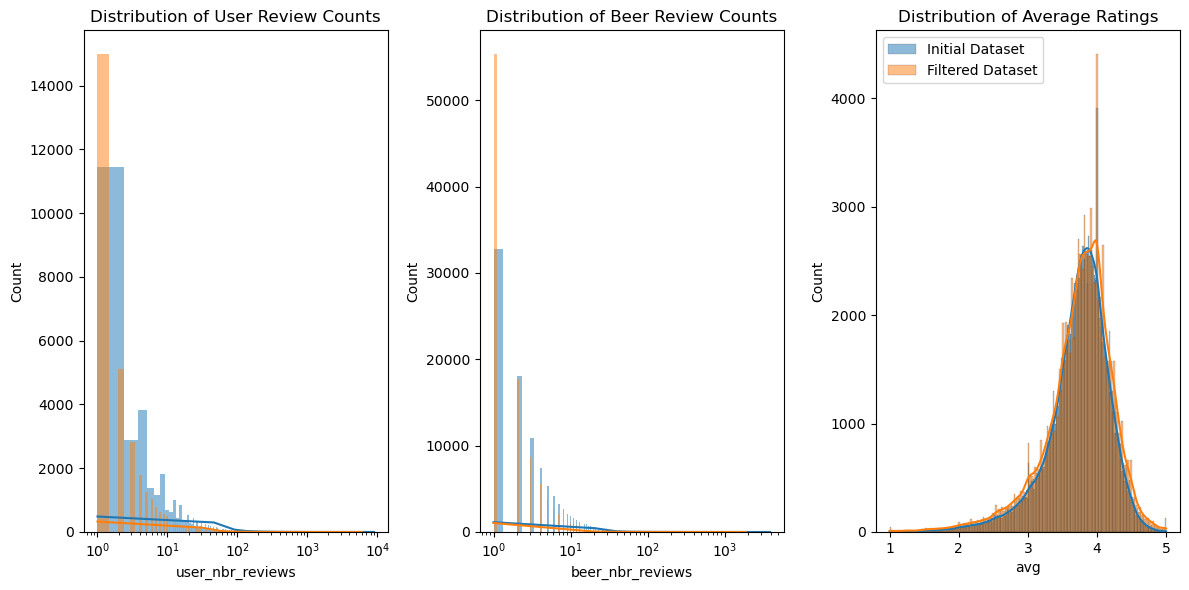

In [17]:
# Check the distribution of key columns to see if they are similar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Distribution of User Review Counts
axes[0].set_title('Distribution of User Review Counts')
sns.histplot(filtered_df_user['user_nbr_reviews'], kde=True, ax=axes[0], label='Initial Dataset')
sns.histplot(filtered_df_user['user_filtered_nbr_reviews'], kde=True, ax=axes[0], label='Filtered Dataset')
#axes[0].set_ylim([1e0, 25000])
axes[0].set_xscale('log')
#axes[0].set_yscale('log')

# Distribution of Beer Review Counts
axes[1].set_title('Distribution of Beer Review Counts')
sns.histplot(filtered_df_beer['beer_nbr_reviews'], kde=True, ax=axes[1], label='Initial Dataset')
sns.histplot(filtered_df_beer['beer_filtered_nbr_reviews'], kde=True, ax=axes[1], label='Filtered Dataset')
#axes[1].set_ylim([1e0, 2000000])
axes[1].set_xscale('log')
#axes[1].set_yscale('log')

# Distribution of Average Ratings
axes[2].set_title('Distribution of Average Ratings')
sns.histplot(filtered_df_beer['avg'], kde=True, ax=axes[2], label='Initial Dataset')
sns.histplot(filtered_df_beer['beer_filtered_avg'], kde=True, ax=axes[2], label='Filtered Dataset')

plt.tight_layout()
plt.legend()
plt.show()

In [18]:
# compare similar infos
t_stat, p_value = ttest_ind(filtered_df_beer['avg'], filtered_df_beer['beer_filtered_avg'])
print("\nT-Test Results: Average Rating")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

filtered_df_beer_std= filtered_df_beer[filtered_df_beer['beer_filtered_std'].notna()]
t_stat, p_value = ttest_ind(filtered_df_beer_std['beer_std'], filtered_df_beer_std['beer_filtered_std'])
print("\nT-Test Results: Standard Deviation of Rating")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_user['user_nbr_reviews'], filtered_df_user['user_filtered_nbr_reviews'])
print("\nT-Test Results: Number of user reviews ")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_nbr_reviews'], filtered_df_beer['beer_filtered_nbr_reviews'])
print("\nT-Test Results: Number of beer reviews ")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")


T-Test Results: Average Rating
T-Statistic: -0.1407391103761723, P-Value: 0.8880761714411514

T-Test Results: Standard Deviation of Rating
T-Statistic: 70.90906003601057, P-Value: 0.0

T-Test Results: Number of user reviews 
T-Statistic: 23.76025885009561, P-Value: 2.4622528061687613e-124

T-Test Results: Number of beer reviews 
T-Statistic: 36.7441592984133, P-Value: 1.0607180926185027e-294


In [19]:
# compare similar infos on appearance, aroma, palate, taste and overall
t_stat, p_value = ttest_ind(filtered_df_beer['beer_avg_appearance'], filtered_df_beer['beer_filtered_avg_appearance'])
print("\nT-Test Results: Average Appearance")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_avg_aroma'], filtered_df_beer['beer_filtered_avg_aroma'])
print("\nT-Test Results: Average Aroma")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_avg_palate'], filtered_df_beer['beer_filtered_avg_palate'])
print("\nT-Test Results: Average Palate")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_avg_taste'], filtered_df_beer['beer_filtered_avg_taste'])
print("\nT-Test Results: Average Taste")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_avg_overall'], filtered_df_beer['beer_filtered_avg_overall'])
print("\nT-Test Results: Average Overall")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")



T-Test Results: Average Appearance
T-Statistic: 2.97058962091007, P-Value: 0.0029725966926776497

T-Test Results: Average Aroma
T-Statistic: 3.4331745261330693, P-Value: 0.000596664000656595

T-Test Results: Average Palate
T-Statistic: 2.7345966084650692, P-Value: 0.006246159286362478

T-Test Results: Average Taste
T-Statistic: 3.6408378951891414, P-Value: 0.00027181235126637473

T-Test Results: Average Overall
T-Statistic: 4.0900597998013675, P-Value: 4.31410003391933e-05


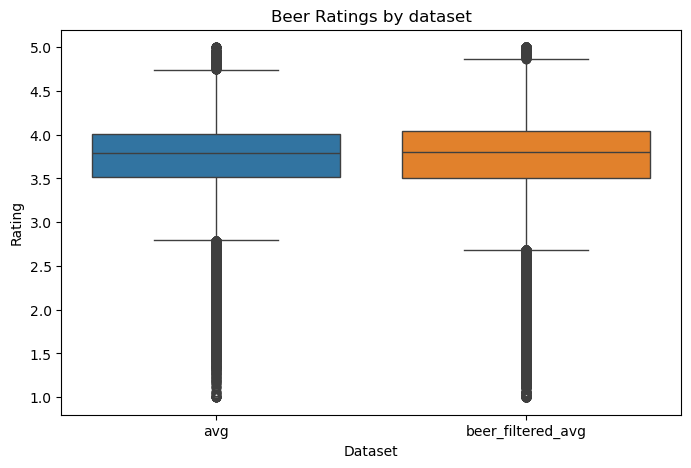

In [20]:
# box plot of the average rating per beer "avg" and the computed average rating per beer "beer_avg_computed" from df_filtered_beer
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_df_beer[['avg', 'beer_filtered_avg']])
plt.title('Beer Ratings by dataset')
plt.xlabel('Dataset')
plt.ylabel('Rating')
plt.show()


In [ ]:

# filtered_df_beer['ci_low'] = filtered_df_beer['beer_filtered_avg_aroma'] - 1.96 * filtered_df_beer['beer_filtered_std_aroma'] / (filtered_df_beer['beer_filtered_nbr_reviews'] ** 0.5), axis=1)
# filtered_df_beer['ci_high'] = filtered_df_beer['beer_filtered_avg_aroma'] + 1.96 * filtered_df_beer['beer_filtered_std_aroma'] / (filtered_df_beer['beer_filtered_nbr_reviews'] ** 0.5), axis=1)

# # Set the style of the visualization
# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))

# plt.bar(grouped_df['beer_id'], grouped_df[('mean', attribute)], yerr=(grouped_df[('ci_low', attribute)], grouped_df[('ci_high', attribute)]), capsize=5, label=attribute, alpha=0.7)

# # Set plot labels and title
# plt.xlabel('Beer ID')
# plt.ylabel('Average Value')
# plt.title('Average Values for Different Attributes with Confidence Intervals')

# # Add legend
# plt.legend()

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Show the plot
# plt.show()


In [12]:
filtered_df_beer.describe()

,beer_nbr_reviews,avg,beer_nbr_reviews_computed,beer_avg_computed
count,113874.000000,113874.000000,113874.000000,113874.000000
mean,22.092954,3.726006,9.516509,3.726292
std,106.845562,0.457103,43.866467,0.509969
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.520000,1.000000,3.500000
50%,3.000000,3.790000,2.000000,3.801429
75%,9.000000,4.010000,4.000000,4.045000
max,3899.000000,5.000000,1881.000000,5.000000


<blockquote>

From these tests, we can see that the dataset is still representative of the initial one. The average rating of a beer is still the same, and the distribution of the ratings is also similar. We can therefore continue our analysis on this dataset.

However, as expected, we lost a lot of reviews, therefore the amount of reviews per beer is statistically significant from the initial amount of reviews per beer. 

We were not sure, if the same conclusion could be drawn for the amount of reviews per user, since some users might always give the serving style or never. At the end, we see that the distribution is still similar, but the amount of reviews per user is statistically significant from the initial amount of reviews per user. 

</blockquote>


## 4. Visualization 📊

> In this step, we just plotted some information, to make sure our intuition was correct. The detailed analysis will come in P3.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


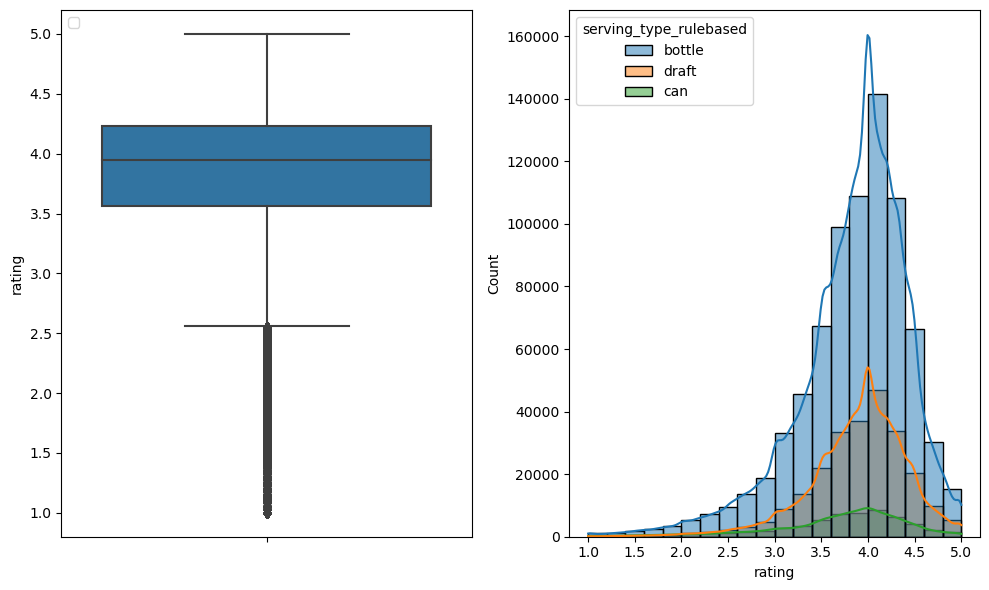

In [25]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type_rulebased', y='rating')
plt.legend(loc='upper left')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type_rulebased', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏
> First draft analysis to look which aspect has more impact on the rating. We will continue this analysis in P3.

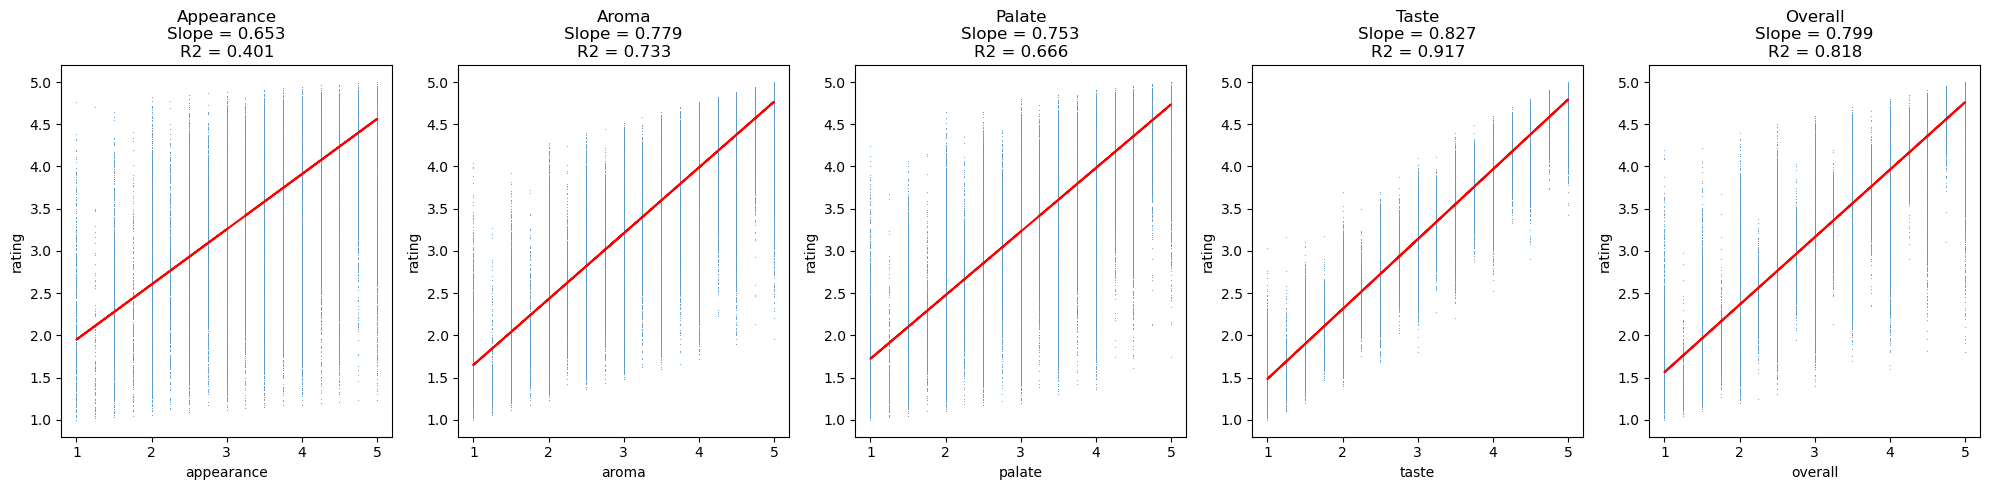

In [26]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

> It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [68]:
def do_ttest(type1: str, type2: str, category: str) -> None:
    """
    Perform a t-test on the two samples of the given category for the given serving types.
    
    Parameters:
    - type1 (str): The first serving type.
    - type2 (str): The second serving type.
    - category (str): The category to perform the t-test on.

    """
    ttest = ttest_ind(df[df['serving_type_rulebased'] == type1][category],df[df['serving_type_rulebased'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

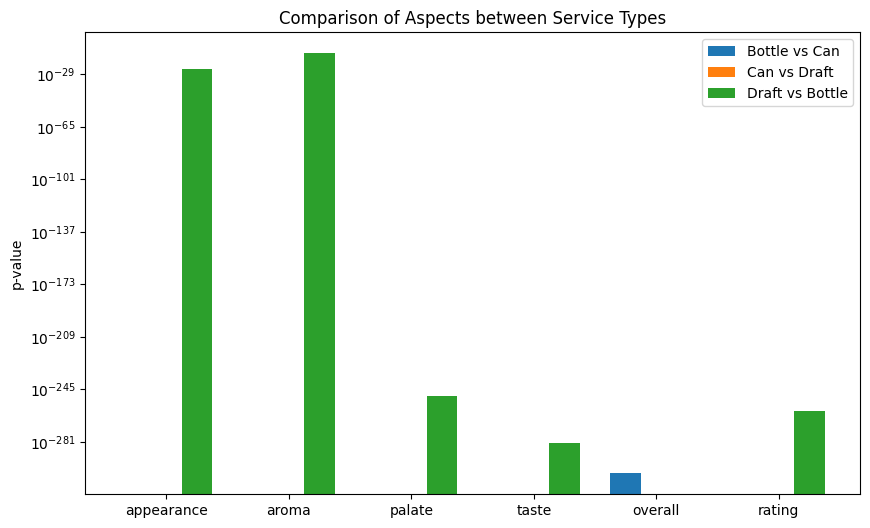

In [69]:
# compare each aspect between all three serving types

# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type_rulebased'] == 'bottle'][columns[i]], df[df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type_rulebased'] == 'can'][columns[i]], df[df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type_rulebased'] == 'draft'][columns[i]], df[df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

> All the p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

C:\Users\victo\AppData\Local\Temp\ipykernel_2496\1834654910.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(151)


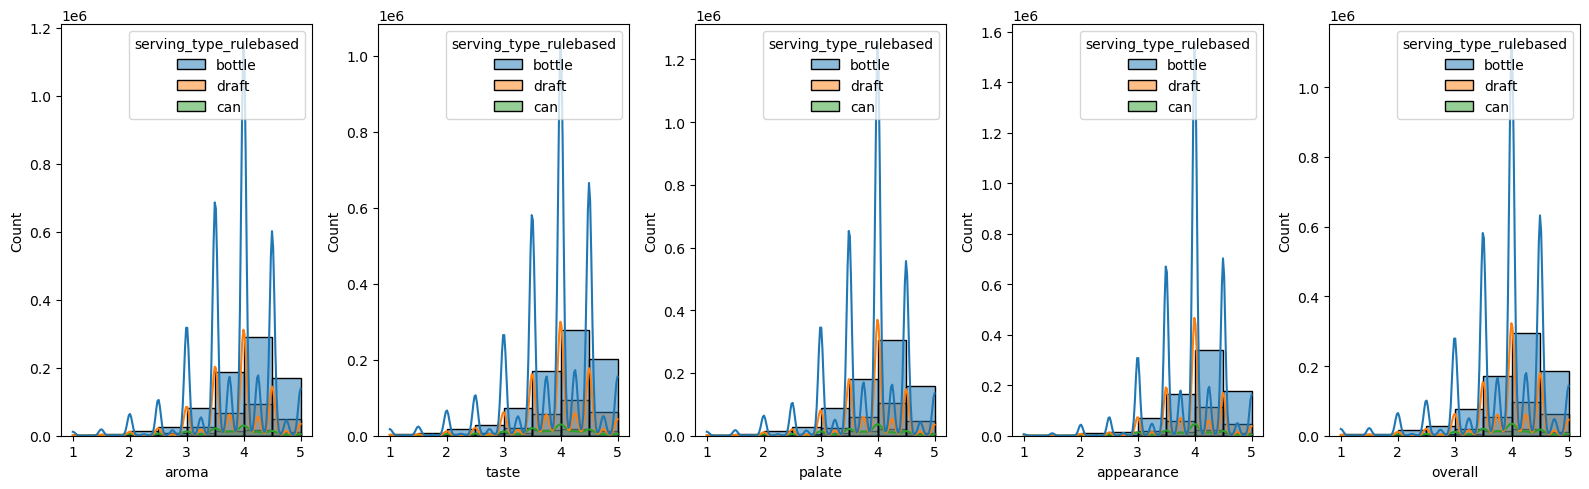

In [32]:
# Task 7.3 : analysis of the serving style on the ratings and tasting palette
# Histogram of the ratings for each serving type
plt.subplots(figsize=(16, 5))
plt.subplot(151)
sns.histplot(data=df, hue='serving_type_rulebased', x='aroma', kde=True, bins=8)
plt.subplot(152)
sns.histplot(data=df, hue='serving_type_rulebased', x='taste', kde=True, bins=8)
plt.subplot(153)
sns.histplot(data=df, hue='serving_type_rulebased', x='palate', kde=True, bins=8)
plt.subplot(154)
sns.histplot(data=df, hue='serving_type_rulebased', x='appearance', kde=True, bins=8)
plt.subplot(155)
sns.histplot(data=df, hue='serving_type_rulebased', x='overall', kde=True, bins=8)
plt.tight_layout()
plt.show()